This file contains code to visualize our emote embedding space using TSNE and detecting potentially toxic HasanAbi emotes using the HasanAbi emotes we know are toxic (based on how close emote is to toxic HasanAbi emote in t-SNE space)

References: https://medium.com/@parkermo_86729/nlp-series-part-2-using-word2vec-word-embeddings-to-explore-semantic-relations-among-new-sources-d91a1371fd08

https://builtin.com/data-science/tsne-python


# Importing necessary modules

In [64]:
import sklearn
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import csv  
import gensim
from sklearn.metrics.pairwise import cosine_similarity

# Read emote embedding space and emote labels

In [65]:
#read embedding space of ONLY emotes into dataframe. Each row corresponds to an emote where every emote is represented as vector of 500 numbers (made using Word2Vec model)
emote_embeddings_df = pd.read_csv("emote_embeddings.tsv", sep = "\t", encoding='utf-8-sig', header = None, quoting= csv.QUOTE_NONE)
print(emote_embeddings_df)

            0         1         2         3         4         5         6    \
0      1.286686  0.975437 -0.105877  0.404266 -0.069233  0.262404  0.398642   
1      0.529400  0.667009 -0.286177  0.307736  0.286603 -0.901467 -0.519312   
2      0.743785  1.555274  1.418502  0.394715 -0.421091 -0.952254  0.439094   
3      0.043058  0.305662  0.128614 -0.744834 -0.107481 -0.263151  0.488091   
4      1.025381  0.266222  0.659756  0.703869  0.033678  0.297028 -0.840579   
...         ...       ...       ...       ...       ...       ...       ...   
65261  0.123776 -0.046080 -0.207358  0.306132 -0.025957  0.054415 -0.058345   
65262 -0.078786 -0.208091 -0.120529  0.192288 -0.080695  0.001563  0.107449   
65263  0.035936  0.121559  0.153296  0.225215  0.017556 -0.115271  0.007538   
65264 -0.010854 -0.175074 -0.021993  0.171712  0.091793  0.198943 -0.111441   
65265 -0.039198 -0.101730  0.035865  0.102303  0.016584  0.064804  0.012547   

            7         8         9    ...       490 

In [66]:
emotes_only_labels_df = pd.read_csv("emote_labels.tsv", sep = '\t', encoding='utf-8-sig', quoting= csv.QUOTE_NONE)
print(emotes_only_labels_df)

               word          source
0               LUL   GLOBAL_TWITCH
1                <3   GLOBAL_TWITCH
2              Clap      GLOBAL_7TV
3                gg  TWITCH_CHANNEL
4                :)   GLOBAL_TWITCH
...             ...             ...
65261  brucegbatman  TWITCH_CHANNEL
65262   matthewbruh  TWITCH_CHANNEL
65263    maxyyagony  TWITCH_CHANNEL
65264     maximumyk  TWITCH_CHANNEL
65265   foggedcorgi  TWITCH_CHANNEL

[65266 rows x 2 columns]


In [67]:
emote_embeddings_array = emote_embeddings_df.to_numpy()
print(emote_embeddings_array)

print(emote_embeddings_array.shape)

[[ 1.2866861   0.9754372  -0.10587668 ... -0.33235487 -1.0189936
  -1.1317601 ]
 [ 0.5294004   0.66700864 -0.28617743 ...  0.96231073 -0.10589289
  -1.2314724 ]
 [ 0.74378496  1.555274    1.4185019  ... -0.1524967  -0.30245277
  -2.6023583 ]
 ...
 [ 0.0359361   0.12155863  0.15329593 ...  0.04337037 -0.20036441
  -0.12745376]
 [-0.01085371 -0.17507392 -0.02199322 ... -0.10171156 -0.02624998
  -0.09837419]
 [-0.03919836 -0.10172977  0.03586481 ... -0.01120612  0.05379896
  -0.02889587]]
(65266, 500)


In [68]:
emote_labels_array = emotes_only_labels_df["word"].to_numpy()
print(emote_labels_array)

print(emote_labels_array.shape)

['LUL' '<3' 'Clap' ... 'maxyyagony' 'maximumyk' 'foggedcorgi']
(65266,)


# Entire emote embedding space

## Train t-SNE model after extracting PCA components

Before doing TSNE on 500 dimensional vectors we will do PCA so we can get better visualizations with TSNE because we have very high dimensional vectors

In [7]:
#Using PCA to extract 100 components from the 500 dimensional vectors 
from sklearn.decomposition import PCA

pca = PCA(n_components = 100, random_state = 42)
pca_result = pca.fit_transform(emote_embeddings_array)

print(pca.explained_variance_ratio_)

[0.03211793 0.02954344 0.01742586 0.01415079 0.01167801 0.0096028
 0.00870129 0.0081807  0.00749245 0.00724629 0.006692   0.00627304
 0.00597578 0.00562087 0.00530061 0.00521603 0.00510277 0.00499279
 0.00479299 0.00466385 0.00441609 0.00438775 0.00424248 0.00417423
 0.0041659  0.00412978 0.00401609 0.00393964 0.00390352 0.00382042
 0.00376711 0.00366442 0.00364985 0.00356915 0.00352491 0.00348088
 0.00342867 0.00338831 0.00332871 0.00324659 0.00323093 0.00321376
 0.00316844 0.00313531 0.00311426 0.00309214 0.00305463 0.00302727
 0.00300547 0.00298657 0.00296895 0.00295257 0.00293545 0.00289468
 0.00287367 0.00286639 0.00282803 0.00281613 0.00279303 0.00274597
 0.00273352 0.00272369 0.00269612 0.00268536 0.00267857 0.00264883
 0.00264039 0.00263489 0.00261339 0.00260081 0.00258212 0.0025426
 0.00252262 0.00251265 0.00249409 0.00249029 0.0024652  0.00245641
 0.00242988 0.00241469 0.00240484 0.00239769 0.00238425 0.0023786
 0.00236765 0.00235473 0.00232954 0.00231499 0.00228896 0.0022785

Cumulative explained variation for principal components: 0.43368679974720203


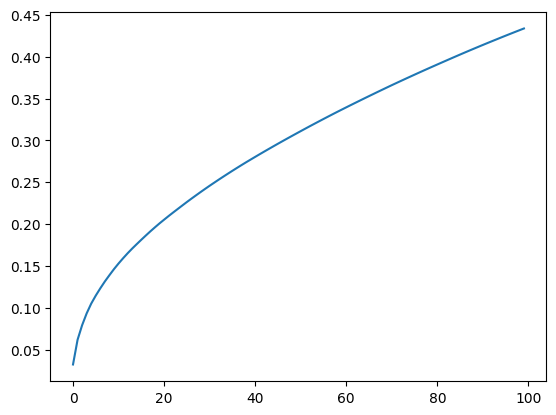

In [9]:
import matplotlib
import matplotlib.pyplot as plt

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1   
plt.plot(cumsum)

print('Cumulative explained variation for principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

In [14]:
tsne = TSNE(n_components = 2, random_state= 42, perplexity = 40, learning_rate = 200, n_iter = 1500)
embeddings_2d = tsne.fit_transform(pca_result)

In [15]:
print(embeddings_2d)

[[ -1.4696733 -56.456734 ]
 [ 10.31042    17.232874 ]
 [ -3.0626721 -56.582294 ]
 ...
 [  9.200284  -38.686848 ]
 [-26.985477  -47.782063 ]
 [-22.855108  -38.143513 ]]


## Visualizing our emote embedding space after TSNE applied on PCA components

In [16]:
import matplotlib
import matplotlib.pyplot as plt

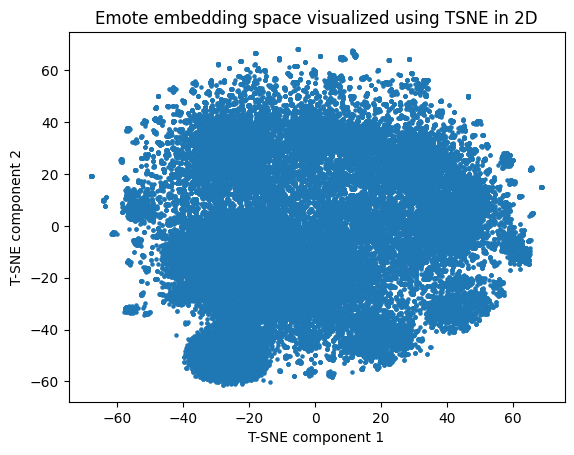

In [18]:
# Plot the t-SNE output
x = embeddings_2d[:, 0]
y = embeddings_2d[:, 1]

plt.scatter(x, y, s = 5)

# #adding labels to emotes
# for i, label in enumerate(emote_labels_array[:]):
#     plt.text(x[i], x[i], label, fontsize=10)

#adding labels to axes and title
plt.xlabel('T-SNE component 1')
plt.ylabel('T-SNE component 2')
plt.title('Emote embedding space visualized using TSNE in 2D')

plt.show()

## Training PCA model on emote embedding space

In [121]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_result3comp = pca.fit_transform(emote_embeddings_array)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.03211793 0.02954344 0.01742585]


In [123]:
print(pca_result3comp.shape)
print(pca_result3comp)

(65266, 3)
[[-1.13830913 -0.53701293 -1.098354  ]
 [ 1.41112191  2.60409485  2.12740582]
 [-0.07461958  0.14111788 -0.69006037]
 ...
 [-0.80706553 -1.05725265  0.18668178]
 [-1.15161628 -1.16889444 -0.51765048]
 [-0.81269821 -0.90854911 -0.36696482]]


Cumulative explained variation for 50 principal components: 0.07908722850949827


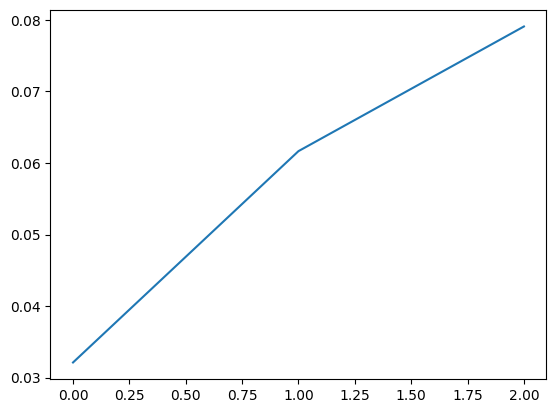

In [117]:
import matplotlib
import matplotlib.pyplot as plt

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1   
plt.plot(cumsum)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

## Visualize emote embedding space after PCA

As we can see, the emote embedding space in PCA looks like one dense cluster ball  because only around 8 percent of total information was captured which is not enough to seperate the emotes into different clusters.

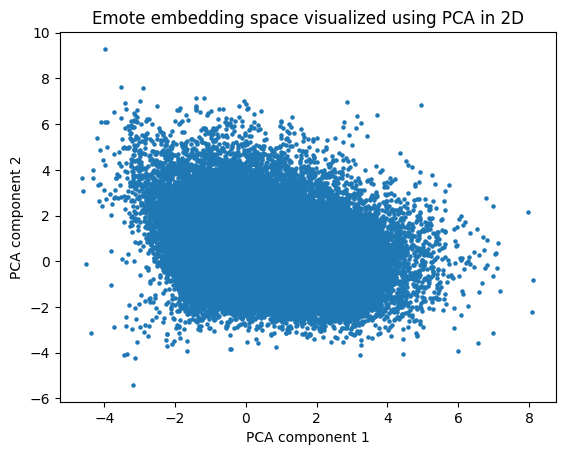

In [124]:
# Plot first two components of PCA
x = pca_result3comp[:, 0]
y = pca_result3comp[:, 1]
    
plt.scatter(x, y, s = 5)


#adding labels to axes and title
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

plt.title('Emote embedding space visualized using PCA in 2D')
    
plt.show()

# Hasan Abi's emote embedding space

## Extract all HasanAbi emotes from emote embedding space

In [ ]:
# Read channel emotes file
channel_emotes_df = pd.read_csv("channel_emotes.csv")

In [70]:
#Renaming columns that start with numbers to avoid potential conflict with pandas 
channel_emotes_df.columns = ['Col_' + str(col) if col[0].isdigit() else col for col in channel_emotes_df.columns]
channel_emotes_df.fillna("", inplace = True) #fill nulls with empty string
channel_emotes_df = channel_emotes_df.reset_index(drop = True)

In [71]:
channel_emotes_df

,Col_1XFRAZX1,Col_20kilo,Col_2thy,Col_360Chrism,Col_39daph,Col_420jenkins,Col_4HEAD,Col_5up,Col_6Cyx,Col_6lasphemous,...,zombs,ZONEsama,Zoomaa,zorgo_hs,ZubatLEL,ZVCH,Zwag,zwebackhd,Zy0xxx,Zyro
0,x1xfraFRAZ,x20kilChest,pvper3hard,chrisAww,daph2head,jenkinsAY,foheadBOZOSPOTTED,5up5Crumb,cyxAAA,x6lasp30k,...,zombsBanger,zoneAAAAA,zoomaa423,zorg1,zub3,oogy1,zwag200iq,zweWOW,zy0xAngy,ttvzyr30
1,x1xfraBlessUP,x20kilChest2,pvperAlarm,chrisAYAYA,daph39,jenkinsBepis,foheadClown,5up5Fu,cyxAYAYA,x6lasp400iL,...,zombsClown,zoneAngy,zoomaaACHES,zorg8,zub420SUBPOINTS,oogy10,zwag6cs,zweAudacity,zy0xBedge,ttvzyrCamera
2,x1xfraFraz,x20kilCoin,pvperAsh,chrisBaited,daphArt,jenkinsChicken,foheadCry,5up5Tubbo,cyxBadAcc,x6lasp400iR,...,zombsDEAL,zoneAYAYA,zoomaaBadaBoom,zorg9,zubAYAYA,oogy2,zwagCannon,zweBaby,zy0xCap,ttvzyrClip
3,x1xfraGG,x20kilDab,pvperBastion,chrisBass,daphBeg,jenkinsOK,foheadDrive,5up7,cyxBased,x6lasp8901,...,zombsFeels,zoneBlush,zoomaaBALLS,zorgBurglar,zubBAIT,oogy25,zwagCool,zweBeta,zy0xClown,ttvzyrEww
4,x1xfraHYPE,x20kilF,pvperBroken,chrisBeg,daphBlind,jenkinsPudge1,foheadGGC,5upBall1,cyxBlank,x6lasp8902,...,zombsGood,zoneBurg,zoomaaBen,zorgCooking,zubBANDIT,oogy3,zwagD,zweBoat,zy0xComfy,ttvzyrGg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,,,,,,,,,,,...,,,,,,,,,,
822,,,,,,,,,,,...,,,,,,,,,,
823,,,,,,,,,,,...,,,,,,,,,,
824,,,,,,,,,,,...,,,,,,,,,,


In [73]:
hasanabi_emotes = channel_emotes_df[["HasanAbi"]]

print(hasanabi_emotes)

#Filter out empty cells
print((hasanabi_emotes == '').sum()) #Number of empty strings in HasanAbi emotes
hasanabi_emotes = hasanabi_emotes[(hasanabi_emotes != '').all(axis = 1)].reset_index(drop = True)

print(hasanabi_emotes)

      HasanAbi
0     has0head
1         has5
2        hasAY
3    hasBaited
4    hasBOOMER
..         ...
821           
822           
823           
824           
825           

[826 rows x 1 columns]
HasanAbi    458
dtype: int64
      HasanAbi
0     has0head
1         has5
2        hasAY
3    hasBaited
4    hasBOOMER
..         ...
363    woeisMe
364     Wokege
365       WTFF
366    xqCaren
367    ZZoomer

[368 rows x 1 columns]


## Label the HasanAbi emotes which we know are toxic

In [75]:
#Read harmful emotes extracted into a dataframe
harmful_emotes_df = pd.read_csv("Harmfulemotes_analysis.csv")
print(harmful_emotes_df)

    Unnamed: 0.1  Unnamed: 0             Emote  \
0              0          82             Gayge   
1              1          97            Wokege   
2              2          99             Sussy   
3              3         105      pepeMeltdown   
4              4         110            monkaS   
5              5         112          has0head   
6              6         126    DANKHACKERMANS   
7              7         160          PepeSpit   
8              8         168         hasSammie   
9              9         171           PoroSad   
10            10         172      StinkyCheese   
11            11         178            MmmHmm   
12            12         179         WhatChamp   
13            13         180          PUNCHIES   
14            14         181      DIESOFCRINGE   
15            15         198           hasKapp   
16            16         207          hasSilly   
17            17         208             FLUSH   
18            18         215            Tastge   


Some of the harmful emotes we identified are actually global in that harmful_emotenalysis.csv file are global so we remove them to get only the toxic HasanAbi emotes

In [77]:
harmfulHasanAbiEmotes_df = harmful_emotes_df[harmful_emotes_df["Channel emote"] == "HasanAbi"].reset_index(drop = True)
harmfulHasanAbiEmotes_df

,Unnamed: 0.1,Unnamed: 0,Emote,Number of times emote was toxic,Number of times emote was NOT toxic,Global emote,Channel emote,Toxicity Ratio,Harmful score
0,1,97,Wokege,16,11,False,HasanAbi,0.592593,27.592593
1,2,99,Sussy,56,13,False,HasanAbi,0.811594,69.811594
2,3,105,pepeMeltdown,10,7,False,HasanAbi,0.588235,17.588235
3,5,112,has0head,8,2,False,HasanAbi,0.800000,10.800000
4,6,126,DANKHACKERMANS,6,1,False,HasanAbi,0.857143,7.857143
5,7,160,PepeSpit,21,12,False,HasanAbi,0.636364,33.636364
6,8,168,hasSammie,4,0,False,HasanAbi,1.000000,5.000000
7,11,178,MmmHmm,1,0,False,HasanAbi,1.000000,2.000000
8,12,179,WhatChamp,8,1,False,HasanAbi,0.888889,9.888889
9,13,180,PUNCHIES,1,0,False,HasanAbi,1.000000,2.000000


In [78]:
harmfulHasanAbiEmotes = harmfulHasanAbiEmotes_df["Emote"] #20 harmful HasanAbi emotes
print(harmfulHasanAbiEmotes)
print(type(harmfulHasanAbiEmotes))

0             Wokege
1              Sussy
2       pepeMeltdown
3           has0head
4     DANKHACKERMANS
5           PepeSpit
6          hasSammie
7             MmmHmm
8          WhatChamp
9           PUNCHIES
10      DIESOFCRINGE
11           hasKapp
12          hasSilly
13             FLUSH
14            Tastge
15            RIDING
16      ItalianHands
17              Grrr
18        dankCrayon
19          peepoBye
Name: Emote, dtype: object
<class 'pandas.core.series.Series'>


In [79]:
print(hasanabi_emotes)

      HasanAbi
0     has0head
1         has5
2        hasAY
3    hasBaited
4    hasBOOMER
..         ...
363    woeisMe
364     Wokege
365       WTFF
366    xqCaren
367    ZZoomer

[368 rows x 1 columns]


Label HasanAbi emotes which are toxic according to the harmful HasanAbi emotes we have

In [80]:
hasanabi_emotes['is_toxic'] = hasanabi_emotes["HasanAbi"].isin(harmfulHasanAbiEmotes)

In [82]:
print(hasanabi_emotes)
print(hasanabi_emotes["is_toxic"].value_counts())

      HasanAbi  is_toxic
0     has0head      True
1         has5     False
2        hasAY     False
3    hasBaited     False
4    hasBOOMER     False
..         ...       ...
363    woeisMe     False
364     Wokege      True
365       WTFF     False
366    xqCaren     False
367    ZZoomer     False

[368 rows x 2 columns]
False    348
True      20
Name: is_toxic, dtype: int64


Now we have the dataframe of HasanAbi emotes and they are labelled with whether they are toxic or not. We can map these emotes to their embeddings

In [83]:
index = 0
hasanabi_emotes["embedding"] = np.nan
print(hasanabi_emotes)

      HasanAbi  is_toxic  embedding
0     has0head      True        NaN
1         has5     False        NaN
2        hasAY     False        NaN
3    hasBaited     False        NaN
4    hasBOOMER     False        NaN
..         ...       ...        ...
363    woeisMe     False        NaN
364     Wokege      True        NaN
365       WTFF     False        NaN
366    xqCaren     False        NaN
367    ZZoomer     False        NaN

[368 rows x 3 columns]


In [84]:
for current_emote in hasanabi_emotes["HasanAbi"]: #Go through each HasanAbi emote (some are harmful/toxic and some are not)
    
    #Search for the index of where we find this emote in the emote labels dataframe
    matching_index = emotes_only_labels_df.index[emotes_only_labels_df['word'] == current_emote].tolist()
    if len(matching_index) == 0: #maybe emote is stored in lowercase form
        matching_index = emotes_only_labels_df.index[emotes_only_labels_df['word'].str.lower() == current_emote.lower()].tolist()
    
    if len(matching_index) == 0: #if emote was not found in the emote labels dataframe
        hasanabi_emotes.at[index, "embedding"] = "Does not exist"
        index += 1
        continue
    
    #Retrieve the 500 element vector corresponding to this emote using the matching_index
    embedding_vector = emote_embeddings_df.iloc[matching_index[0]].values
    #print(type(embedding_vector))

    hasanabi_emotes.iloc[index, hasanabi_emotes.columns.get_loc("embedding")] = np.array_str(embedding_vector)
    index += 1

print(hasanabi_emotes)

      HasanAbi  is_toxic                                          embedding
0     has0head      True  [ 1.37839720e-01 -3.40588200e-02  3.96217230e-...
1         has5     False  [-8.20994900e-01 -1.42091270e-01  1.84934460e-...
2        hasAY     False  [-9.39330000e-01  8.88686850e-02 -9.86998300e-...
3    hasBaited     False  [-3.97825360e-01 -6.52410300e-01  8.84840700e-...
4    hasBOOMER     False  [-3.17919050e-01 -3.86311400e-02 -3.31497760e-...
..         ...       ...                                                ...
363    woeisMe     False                                     Does not exist
364     Wokege      True                                     Does not exist
365       WTFF     False                                     Does not exist
366    xqCaren     False                                     Does not exist
367    ZZoomer     False                                     Does not exist

[368 rows x 3 columns]


Many HasanAbi emotes (including the channel bttv ones) just do not have embeddings in the emote embedding dataframe

In [85]:
print((hasanabi_emotes["embedding"] == 'Does not exist').sum())

#Filter out emotes which don't have an embedding since we cannot compute the similarity of those emotes to the HasanAbi emotes
hasanabi_emotes = hasanabi_emotes[hasanabi_emotes["embedding"] != 'Does not exist'].reset_index(drop = True)
print(hasanabi_emotes)

293
      HasanAbi  is_toxic                                          embedding
0     has0head      True  [ 1.37839720e-01 -3.40588200e-02  3.96217230e-...
1         has5     False  [-8.20994900e-01 -1.42091270e-01  1.84934460e-...
2        hasAY     False  [-9.39330000e-01  8.88686850e-02 -9.86998300e-...
3    hasBaited     False  [-3.97825360e-01 -6.52410300e-01  8.84840700e-...
4    hasBOOMER     False  [-3.17919050e-01 -3.86311400e-02 -3.31497760e-...
..         ...       ...                                                ...
70       Stare     False  [ 2.75475770e-01 -4.00699380e-01 -1.32715820e+...
71    sumSmash     False  [-3.50056650e-01 -6.38177600e-02 -2.23187630e-...
72     TeaTime     False  [-0.99884254 -0.45608458 -0.28528324 -0.344044...
73  WAYTOODANK     False  [ 2.01232340e-01  1.37800630e+00 -3.69203930e-...
74    WineTime     False  [-1.50388300e+00 -1.29018840e+00  4.01657970e-...

[75 rows x 3 columns]


In [86]:
print(hasanabi_emotes["is_toxic"].value_counts())

False    71
True      4
Name: is_toxic, dtype: int64


In [87]:
hasanabiembeddingsarray = np.zeros((75, 500))

#go through each rw
for index, row in hasanabi_emotes.iterrows():
    elements = row["embedding"].replace('[', '').replace(']', '').split()
    #Convery to numpy array
    arr = np.array(elements, dtype=float)
    hasanabiembeddingsarray[index] = arr

In [88]:
print(hasanabiembeddingsarray, hasanabiembeddingsarray.shape)

[[ 0.13783972 -0.03405882  0.39621723 ... -1.0821965   0.33165836
  -0.47801593]
 [-0.8209949  -0.14209127  0.01849345 ...  0.23785803  1.0612733
  -0.22610746]
 [-0.93933     0.08886869 -0.9869983  ... -0.7714897   0.29356965
  -0.9408623 ]
 ...
 [-0.99884254 -0.45608458 -0.28528324 ... -0.7998582   0.7744122
  -0.5813083 ]
 [ 0.20123234  1.3780063  -0.36920393 ... -0.6883285   0.53371143
  -0.8311688 ]
 [-1.503883   -1.2901884   0.40165797 ... -1.134951    0.1913732
   0.637556  ]] (75, 500)


In [89]:
print(type(hasanabiembeddingsarray))
print(hasanabiembeddingsarray.shape)


<class 'numpy.ndarray'>
(75, 500)


## Train TSNE on HasanAbi embeddings

PCA is not needed before t-SNE for only HasanAbi's embeddings because its only a few emotes (unlike the entire emote embedding space which had over 65k emotes)

In [90]:
tsne = TSNE(n_components = 2, random_state= 42, perplexity = 15, learning_rate = 5, n_iter = 500)
embeddings_2d = tsne.fit_transform(hasanabiembeddingsarray)

In [91]:
print(embeddings_2d)
print(embeddings_2d.shape)

[[-2.13540745e+00 -2.68738532e+00]
 [-1.26181912e+00 -1.34126043e+00]
 [-1.07306385e+00 -1.20958716e-01]
 [-2.06585574e+00 -1.45692956e+00]
 [-1.89615619e+00 -8.11303854e-01]
 [-1.43755639e+00  5.49130976e-01]
 [ 1.68184328e+00 -1.35026860e+00]
 [-2.22787976e+00 -2.81433630e+00]
 [-7.46642172e-01 -2.15946287e-02]
 [-1.78143477e+00 -4.08440161e+00]
 [-2.46506527e-01 -2.81216167e-02]
 [-1.89373994e+00 -5.54693162e-01]
 [-1.62298095e+00 -1.18755913e+00]
 [-7.47220218e-01 -8.03847969e-01]
 [ 1.50233805e+00 -1.30745578e+00]
 [-8.30236197e-01 -9.39019799e-01]
 [-1.93448937e+00 -8.50590944e-01]
 [-2.76667792e-02 -1.35774183e+00]
 [-3.60066473e-01 -1.55407226e+00]
 [ 7.11056769e-01  9.35327232e-01]
 [-2.59497046e+00 -8.77464354e-01]
 [ 6.79637671e-01  9.33010340e-01]
 [-1.98355567e+00 -1.62658191e+00]
 [-1.73919916e+00 -3.95279813e+00]
 [ 3.10394138e-01 -1.87628245e+00]
 [ 6.34702206e-01  8.80805433e-01]
 [ 2.43335509e+00  4.91856247e-01]
 [-1.37972689e+00 -1.04359722e+00]
 [-7.73948133e-01 -2

## Visualize HasanAbi embedding space after TSNE

In [92]:
matching_i = hasanabi_emotes.index[hasanabi_emotes["is_toxic"] == True].tolist()

matching_i

[0, 22, 47, 48]

In [93]:
print(hasanabi_emotes["HasanAbi"][matching_i]) 

0      has0head
22      hasKapp
47    hasSammie
48     hasSilly
Name: HasanAbi, dtype: object


In [94]:
import plotly.express as px

In [97]:
# Plot the t-SNE output
x = embeddings_2d[:, 0]
y = embeddings_2d[:, 1]

df = pd.DataFrame(embeddings_2d, columns = ["t-SNE component 1", "t-SNE component 2"])
df["emote_label"] = hasanabi_emotes["HasanAbi"]
df["toxicity_label"] = 'not toxic'
df.loc[matching_i,'toxicity_label'] = 'toxic'

print(df)

    t-SNE component 1  t-SNE component 2 emote_label toxicity_label
0           -2.135407          -2.687385    has0head          toxic
1           -1.261819          -1.341260        has5      not toxic
2           -1.073064          -0.120959       hasAY      not toxic
3           -2.065856          -1.456930   hasBaited      not toxic
4           -1.896156          -0.811304   hasBOOMER      not toxic
..                ...                ...         ...            ...
70          -3.806734          -2.416761       Stare      not toxic
71          -2.502706          -0.173304    sumSmash      not toxic
72          -4.242497          -0.551703     TeaTime      not toxic
73          -3.336781           0.727221  WAYTOODANK      not toxic
74          -4.198702          -1.034545    WineTime      not toxic

[75 rows x 4 columns]


In [99]:
# Interactive plot with Plotly
color_map = {'toxic': '#FF0000', 'not toxic': '#1f77b4', "potentially toxic": '#FF8000'}

#Plotting the scatter plot
fig = px.scatter(df, x='t-SNE component 1', y='t-SNE component 2', color = 'toxicity_label', color_discrete_map = color_map, title='HasanAbi embedding space visualized using t-SNE in 2D', width = 800, height = 600, hover_data={'emote_label': True, "toxicity_label": True})

# Radius for the circle around red points
radius = 0.5

# Iterate through red toxic points
for i in range(len(df)):
    if df['toxicity_label'][i] == 'toxic':
        x_red, y_red = df['t-SNE component 1'][i], df['t-SNE component 2'][i]
        
        # Add circle shape around red points (toxic ones)
        fig.add_shape(
            type='circle',
            x0=x_red - radius,
            y0=y_red - radius,
            x1=x_red + radius,
            y1=y_red + radius,
            line=dict(color='black', width=1),
            # fillcolor='rgba(0,0,0,0)'
        )
        
        for j in range(len(df)):
            if df['toxicity_label'][j] == 'not toxic':
                x_blue, y_blue = df['t-SNE component 1'][j], df['t-SNE component 2'][j]
                distance = np.sqrt((x_blue - x_red) ** 2 + (y_blue - y_red) ** 2)
                
                # Check if blue point falls within the radius
                if distance <= radius:
                    # Assigning orange color to blue point
                    df.at[j, 'toxicity_label'] = 'potentially toxic'



fig.update_layout(
    plot_bgcolor='white',  # Set background color to white
    xaxis=dict(showgrid=False, showline = True, linecolor = "black", linewidth = 1, mirror = True),  #x axis line
    yaxis=dict(showgrid=False, showline=True, linecolor='black', linewidth=1, mirror = True),  # Hide grid lines for the y-axis
    margin=dict(l=50, r=50, t=50, b=50),  # Adjusting margins for better visibility
    font=dict(family="sans-serif", size= 14),

    title = {
        'x': 0.45,
        'y': 0.97
    }

)

fig.show()